In [2]:
import pandas as pd
import numpy as np
import pickle
import os
from collections import Counter

import sys
sys.path.append("/home/ualtintas/bluegill/")
import bluegill.run as bgrun
import bluegill.plt as bgplt

In [3]:

BED = pd.read_table('data/CRE.bed', names=['Chr', 'Start', 'End', 'Name'])

# >>> 1 >>>
BWS = []
for signal in ["ATAC","H3K27ac", "H3K4me3","RNAseq", 'AR', 'FOXA1']:
    for h in ["Vh","30m","4h","16h","72h"]:
        BWS += [f"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/{signal}_{h}.bw"]
# <<< 1 <<<

#/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/

In [31]:
%%bash

path=/groups/lackgrp/projects/col-matt-LNCaP/ProcessedDataSeo/ATAC.BED
parallel cat $path/AT{}* '|' "awk '{if (\$9 > 10) print \$0}' " '|' cut -f1-3 '|' sort -k1,1 -k2,2n '|' bedtools merge -i - '>' data/ATAC.{}.bed  ::: Vh 30m 4h 16h 72h

cat data/ATAC* \
| cut -f1-3 \
| sort -k1,1 -k2,2n \
| bedtools merge -i - \
| bedtools intersect -a - -b /groups/lackgrp/genomeAnnotations/hg19/hg19-blacklist.v2.bed -v \
| grep -v '-' | grep -v '_' \
>  data/ATAC_ALL.raw.bed

bedtools intersect -a data/ATAC_ALL.raw.bed -b data/CRE.bed  -wa -wb \
| cut -f1-3,7  > data/ATAC_CRE.raw.bed

In [2]:
BED = pd.read_table('data/ATAC_CRE.raw.bed', names=['Chr', 'Start', 'End', 'Name'])

In [ ]:
Nbins=1
h=1000

BED, samples = bgrun.runSignal(BED, BWS, "data/Epigenome.p",  Nbins=Nbins, h=h, nP=100)

In [ ]:


S = pickle.load(open("data/Epigenome.p","rb"))
N = np.concatenate((
    bgrun.runTMM(S[:,0:5,:])[:,:,0],
    bgrun.runTMM(S[:,5:10,:])[:,:,0],
    bgrun.runTMM(S[:,10:15,:])[:,:,0],
    bgrun.runTMM(S[:,15:20,:])[:,:,0],
    bgrun.runTMM(S[:,20:25,:])[:,:,0],
    bgrun.runTMM(S[:,25:30,:])[:,:,0]),
    axis=1)
samples = [s.split('/')[-1].split('.')[0] for s in BWS]
N = pd.DataFrame(N, columns=samples, index=BED['Name']).drop_duplicates()
N.to_csv('data/Epigenome.tmm.tsv', sep='\t')
N

# TF ChIPseq

In [ ]:

path = "/groups/lackgrp/projects/inv-berkay-gi/chipseq_pipeline/results_hg19/bigwig/"


BWS = [
    path+bw
    for bw in os.listdir(path)
    if bw.find('rawcount') != -1
]


Nbins=1
h=1000

BED, samples = bgrun.runSignal(BED, BWS, "data/TF.RC.p",  Nbins=Nbins, h=h, nP=100)

In [ ]:


S = pickle.load(open("data/TF.RC.p","rb"))
N = bgrun.runTMM(S)[:,:,0]
samples = [s.split('_')[-1].split('.')[0] for s in BWS]
samples[samples.index('1')] = 'NKX3_1'
N = pd.DataFrame(N, columns=samples, index=BED['Name'])
N.to_csv('data/TF.tmm.tsv', sep='\t')
N

In [ ]:

path = "/groups/lackgrp/projects/inv-berkay-gi/chipseq_pipeline/results_hg19/cabws/"


BWS = [
    path+bw
    for bw in os.listdir(path)
    if bw.find('.bw') != -1
]


Nbins=1
h=1000

BED, samples = bgrun.runSignal(BED, BWS, "data/TF.CA.p",  Nbins=Nbins, h=h, nP=100, type_='max')

In [ ]:


S = pickle.load(open("data/TF.CA.p","rb"))
N = bgrun.runTMM(S)[:,:,0]
samples = [s.split('_',3)[-1].rsplit('.',1)[0] for s in BWS]

N = pd.DataFrame(N, columns=samples, index=BED['Name'])
N.to_csv('../data/TABLE/TF.CA.tmm.tsv', sep='\t')
N


# EtOH vs ANDROGEN

In [ ]:
meta = pd.read_table('/groups/lackgrp/projects/inv-berkay-gi/chipseq_pipeline/config/geo_samples.tsv')

meta = meta.loc[~meta['Treatment'].isna()]
meta['TF'] = meta['Name'].str.split('_', expand=True)[1]
meta['Rep'] = meta['Name'].str.rsplit('_', 1, expand=True)[1]
meta

In [ ]:
meta[meta['TF'] == 'AR']

In [ ]:

path = "/groups/lackgrp/projects/inv-berkay-gi/chipseq_pipeline/results_hg19/cabws/"


BWS = [
    path+bw+'.'+gsm+'.bw'
    for bw, gsm in zip(meta['Name'], meta['GSM'])
]


Nbins=1
h=1000

BED, samples = bgrun.runSignal(BED, BWS, "data/TF.CA.ETvsAN.p",  Nbins=Nbins, h=h, nP=30, type_='max')

In [ ]:


S = pickle.load(open("data/TF.CA.ETvsAN.p","rb"))
N = bgrun.runTMM(S)[:,:,0]

M = np.zeros((N.shape[0],len(meta.groupby(['Treatment', 'TF']).groups)))
m = []
for i, (g, idx) in enumerate(meta.groupby(['Treatment', 'TF']).groups.items()):
    M[:, i] = N[:,idx].mean(1)
    m.append(g)

meta_m = pd.DataFrame(m, columns=['Treatment', 'TF'])

meta_m.groupby('TF').groups

L = np.zeros((N.shape[0],len(meta_m.groupby(['TF']).groups)))
l = []
for i, (g, idx) in enumerate(meta_m.groupby(['TF']).groups.items()):
    L[:, i] = np.log2((M[:,idx[0]]+1) / (M[:,idx[1]]+1))
    l.append(g)

meta_l = pd.DataFrame(l, columns=['TF'])
L = pd.DataFrame(L, columns=meta_l['TF'], index=BED['Name'])
L.to_csv('../data/TABLE/TF.LFC.tsv', sep='\t')

M = pd.DataFrame(M, columns=meta_m['TF'] +'_'+ meta_m['Treatment'], index=BED['Name'])
M.to_csv('../data/TABLE/TF.NEW.tsv', sep='\t')

In [ ]:


S = pickle.load(open("data/TF.CA.ETvsAN.p","rb"))
N = bgrun.runTMM(S)[:,:,0]

N = pd.DataFrame(N, columns=samples, index=BED['Name'])
N.to_csv('data/TF.tmm.tsv', sep='\t')
N

# STAR

In [ ]:
BWS = [
    '/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS31_Vehicle-Rep-1.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS31_Vehicle-Rep-1.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS33_30m-DHT-Rep-1.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS33_30m-DHT-Rep-1.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS34_4hr-DHT-Rep-1.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS34_4hr-DHT-Rep-1.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS35_16hr-DHT-Rep-1.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS35_16hr-DHT-Rep-1.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS36_72hr-DHT-Rep-1.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS36_72hr-DHT-Rep-1.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS37_Vehicle-Rep-2.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS37_Vehicle-Rep-2.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS39_30m-DHT-Rep-2.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS39_30m-DHT-Rep-2.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS40_4hr-DHT-Rep-2.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS40_4hr-DHT-Rep-2.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS41_16hr-DHT-Rep-2.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS41_16hr-DHT-Rep-2.REVERSE.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS42_72hr-DHT-Rep-2.FORWARD.bw',
	'/groups/lackgrp/projects/col-matt-LNCaP/results/bigwig/SS42_72hr-DHT-Rep-2.REVERSE.bw'
]

Nbins=1
h=100

BED, samples = bgrun.runSignal(BED, BWS, "data/STAR.p",  Nbins=Nbins, h=h, nP=100, type_='max')

In [ ]:


S = pickle.load(open("data/STAR.p","rb"))
S = bgrun.runTMM(S)[:,:,0]

F = np.zeros((len(S), 5))
R = np.zeros((len(S), 5))

for i in range(5):
    F[:,i] = (S[:,2*i] + S[:,(2*i)+10]) / 2
    R[:,i] = (S[:,2*i+1] + S[:,(2*i)+11]) / 2



S = pd.DataFrame(np.concatenate((F,R), 1), columns=['Vh_F', '30m_F', '4h_F', '16h_F', '72h_F', 'Vh_R', '30m_R', '4h_R', '16h_R', '72h_R'], index=BED['Name'])

S.to_csv('../data/TABLE/STAR.tsv', sep='\t')




# Last Final I hope
?

In [4]:
path = '/groups/lackgrp/ll_members/berkay/1-notebook/col-matt-LNCaP/data/CHIPALTAS/BW_FINAL'

#BWS += [f'{path}/{f}' for f in os.listdir('/groups/lackgrp/ll_members/berkay/1-notebook/col-matt-LNCaP/May-23/nca') if f.find('.bw') != -1]
BWS = []
for signal in ["ATAC","H3K27ac", "H3K4me3", 'AR', 'FOXA1']:
    for h in ["Vh","16h"]:
        BWS += [f"/groups/lackgrp/projects/col-matt-LNCaP/SIGNAL/{signal}_{h}.bw"]
        

BWS += [f'{path}/{f}' for f in os.listdir(path) if f.find('.bw') != -1]


path='/groups/lackgrp/projects/inv-wholegenomeSTARRseq/investigation/genomecov_tracks'
BWS += [f'{path}/LNCaP.WG.DHT.R1.genomecov.RPM.bw',f'{path}/LNCaP.WG.DHT.R2.genomecov.RPM.bw',f'{path}/LNCaP.WG.DHT.R3.genomecov.RPM.bw',f'{path}/LNCaP.WG.EtOH.R1.genomecov.RPM.bw',f'{path}/LNCaP.WG.EtOH.R2.genomecov.RPM.bw',f'{path}/LNCaP.WG.EtOH.R3.genomecov.RPM.bw']

In [4]:
Nbins=100
h=2500

BED, samples = bgrun.runSignal(BED, BWS, "data/LR.p",  Nbins=Nbins, h=h, nP=50, type_='mean')

0: ATAC_Vh.bw :: 1: ATAC_Vh.bw :: 2: ATAC_Vh.bw :: 3: ATAC_Vh.bw :: 4: ATAC_Vh.bw :: 5: ATAC_Vh.bw ::  :: 6: ATAC_Vh.bw7: ATAC_Vh.bw :: 8: ATAC_Vh.bw :: 9: ATAC_Vh.bw :: 10: ATAC_Vh.bw ::  :: 11: ATAC_Vh.bw12: ATAC_Vh.bw :: 13: ATAC_Vh.bw :: 14: ATAC_Vh.bw ::  :: 15: ATAC_Vh.bw16: ATAC_Vh.bw :: 17: ATAC_Vh.bw :: 18: ATAC_Vh.bw :: 19: ATAC_Vh.bw :: 20: ATAC_Vh.bw :: 21: ATAC_Vh.bw :: 22: ATAC_Vh.bw :: 23: ATAC_Vh.bw :: 24: ATAC_Vh.bw :: 26: ATAC_Vh.bw25: ATAC_Vh.bw ::  :: 27: ATAC_Vh.bw :: 28: ATAC_Vh.bw :: 29: ATAC_Vh.bw :: 30: ATAC_Vh.bw :: 31: ATAC_Vh.bw :: 32: ATAC_Vh.bw :: 33: ATAC_Vh.bw ::  :: 34: ATAC_Vh.bw35: ATAC_Vh.bw :: 36: ATAC_Vh.bw :: 37: ATAC_Vh.bw :: 38: ATAC_Vh.bw :: 39: ATAC_Vh.bw :: 40: ATAC_Vh.bw :: 41: ATAC_Vh.bw :: 42: ATAC_Vh.bw :: 43: ATAC_Vh.bw :: 44: ATAC_Vh.bw :: 45: ATAC_Vh.bw :: 46: ATAC_Vh.bw :: 47: ATAC_Vh.bw :: 48: ATAC_Vh.bw :: 49: ATAC_Vh.bw :: 0: ATAC_16h.bw :: 2: ATAC_16h.bw :: 9: ATAC_16h.bw :: 6: ATAC_16h.bw :: 1: ATAC_16h.bw :: 12: ATAC_16h.bw :: 8

In [5]:
S = pickle.load(open("data/LR.p","rb"))
N = bgrun.runTMM(np.nan_to_num(S))



In [ ]:
path = '/groups/lackgrp/ll_members/berkay/1-notebook/col-matt-LNCaP/data/CHIPALTAS/BW_FINAL'
meta = pd.DataFrame({'Samples': \
    [f"{signal}_{h}_1" for signal in ["ATAC","H3K27ac", "H3K4me3", 'AR', 'FOXA1'] for h in ["VEH","TRE"]] + \
    ['_'.join(s.split('/')[-1].split('.')[0].split('_')[:3]) for s in  [f'{path}/{f}' for f in os.listdir(path) if f.find('.bw') != -1]] + \
    ['STARR_TRE_1','STARR_TRE_2','STARR_TRE_3', 'STARR_VEH_1','STARR_VEH_2','STARR_VEH_3']})


meta['Name'] = meta['Samples'].str.rsplit('_',1, expand=True)[0]


A = np.zeros((N.shape[0], meta['Name'].nunique()))
i = 0
for n, idx in meta.groupby('Name').groups.items():
    #S[:,i] = N[:,idx,:].mean(1)
    tmp = N[:,idx,:].mean(1)
    flat = tmp.flatten()
    sorted_flat = np.sort(flat/sum(flat))
    cum = np.cumsum(sorted_flat)
    x = np.linspace(0,1,num=len(cum))
    max_diff = np.argmax(x-cum)
    elbow = np.percentile(sorted_flat[max_diff:]*sum(flat),50)
    A[:,i] = (tmp * (tmp > elbow)).sum(1)
    i+=1


In [ ]:
samples = list(meta.groupby('Name').groups.keys())
SS = pd.DataFrame(A, columns=samples, index=BED['Name'])
SS.to_csv('../data/TABLE/LR.A_sum.tsv', sep='\t')

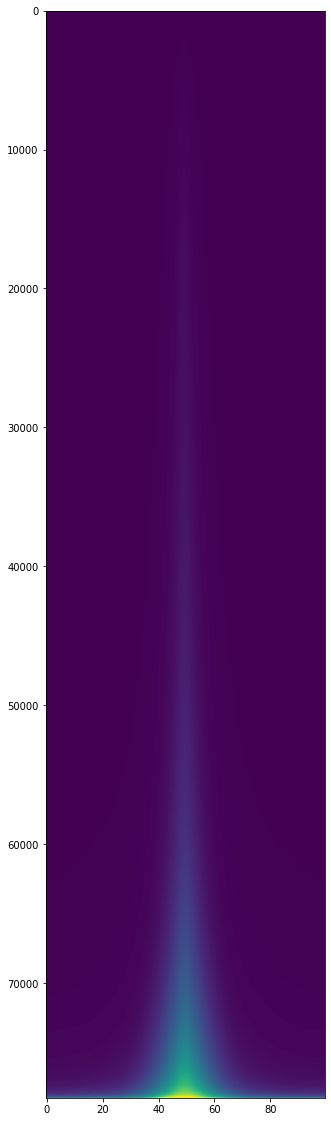

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=[5,20])
plt.imshow(np.sort(N[:,0,:],0),aspect='auto', vmax=1000)

In [7]:
N.shape

(78253, 140, 100)

In [87]:
S = pickle.load(open("data/LR.p","rb"))
N = bgrun.runTMM(np.nan_to_num(S))



path = '/groups/lackgrp/ll_members/berkay/1-notebook/col-matt-LNCaP/data/CHIPALTAS/BW_FINAL'
meta = pd.DataFrame({'Samples': \
    [f"{signal}_{h}_1" for signal in ["ATAC","H3K27ac", "H3K4me3", 'AR', 'FOXA1'] for h in ["VEH","TRE"]] + \
    ['_'.join(s.split('/')[-1].split('.')[0].split('_')[:3]) for s in  [f'{path}/{f}' for f in os.listdir(path) if f.find('.bw') != -1]] + \
    ['STARR_TRE_1','STARR_TRE_2','STARR_TRE_3', 'STARR_VEH_1','STARR_VEH_2','STARR_VEH_3']})


meta['Name'] = meta['Samples'].str.rsplit('_',1, expand=True)[0]


A = np.zeros((N.shape[0], meta['Name'].nunique()))
G = np.zeros((N.shape[0], meta['Name'].nunique()))
i = 0
for n, idx in meta.groupby('Name').groups.items():
    #S[:,i] = N[:,idx,:].mean(1)
    tmp = N[:,idx,:].mean(1)
    flat = tmp.flatten()
    sorted_flat = np.sort(flat/sum(flat))
    cum = np.cumsum(sorted_flat)
    x = np.linspace(0,1,num=len(cum))
    max_diff = np.argmax(x-cum)
    elbow = np.percentile(sorted_flat[max_diff:]*sum(flat),50)
    A[:,i] = ((tmp * (tmp > elbow)).sum(1)+1) / ((tmp > elbow).sum(1)+1)
    G[:,i] = ((tmp * (tmp > elbow)).prod(1)+1) ** (1/((tmp > elbow).sum(1)+1))
    i+=1




In [104]:


path = '/groups/lackgrp/ll_members/berkay/1-notebook/col-matt-LNCaP/data/CHIPALTAS/BW_FINAL'
meta = pd.DataFrame({'Samples': \
    [f"{signal}_{h}_1" for signal in ["ATAC","H3K27ac", "H3K4me3", 'AR', 'FOXA1'] for h in ["VEH","TRE"]] + \
    ['_'.join(s.split('/')[-1].split('.')[0].split('_')[:3]) for s in  [f'{path}/{f}' for f in os.listdir(path) if f.find('.bw') != -1]] + \
    ['STARR_TRE_1','STARR_TRE_2','STARR_TRE_3', 'STARR_VEH_1','STARR_VEH_2','STARR_VEH_3']})


meta['Name'] = meta['Samples'].str.rsplit('_',1, expand=True)[0]


A = np.zeros((N.shape[0], meta['Name'].nunique()))
G = np.zeros((N.shape[0], meta['Name'].nunique()))
i = 0
for n, idx in meta.groupby('Name').groups.items():
    #S[:,i] = N[:,idx,:].mean(1)
    tmp = N[:,idx,:].mean(1)
    flat = tmp.flatten()
    sorted_flat = np.sort(flat/sum(flat))
    cum = np.cumsum(sorted_flat)
    x = np.linspace(0,1,num=len(cum))
    max_diff = np.argmax(x-cum)
    elbow = np.percentile(sorted_flat[max_diff:]*sum(flat),50)
    A[:,i] = ((tmp * (tmp > elbow)).sum(1)+1) / ((tmp > elbow).sum(1)+1)
    G[:,i] = (tmp * (tmp > elbow)+1).prod(1) ** (1/((tmp > elbow).sum(1)))
    i+=1




/tmp/ipykernel_105688/3686552488.py:24: RuntimeWarning: divide by zero encountered in true_divide
  G[:,i] = (tmp * (tmp > elbow)+1).prod(1) ** (1/((tmp > elbow).sum(1)))
/home/ualtintas/miniconda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


In [108]:
samples = list(meta.groupby('Name').groups.keys())
SS = pd.DataFrame(A, columns=samples, index=BED['Name'])
SS.to_csv('../data/TABLE/LR.A_cum.tsv', sep='\t')

samples = list(meta.groupby('Name').groups.keys())
SS = pd.DataFrame(G, columns=samples, index=BED['Name'])
SS.to_csv('../data/TABLE/LR.G_cum.tsv', sep='\t')

In [107]:
G

array([[26.73643212, 22.62984338, 30.52315206, ..., 54.37607998,
        28.610404  , 23.0053631 ],
       [26.12573504, 23.15979927, 42.53525982, ..., 60.27166772,
        26.80637794, 23.73205876],
       [25.20612085, 22.60584804, 30.52315206, ..., 51.73057616,
        22.34314868, 22.03060788],
       ...,
       [26.57166264, 18.72632625,  1.        , ..., 51.73057616,
        22.52885127,  1.        ],
       [24.49919283, 21.19818781, 29.20492103, ...,  1.        ,
        19.79917592, 18.74455101],
       [39.11767483, 21.45028543, 29.20492103, ..., 51.73057616,
        23.80657445, 21.44065079]])

In [102]:
(tmp > elbow).sum(1)

array([34, 43, 34, ...,  0,  6, 11])

In [103]:
(tmp * (tmp > elbow)+1).prod(1) ** (1/((tmp > elbow).sum(1)))

/tmp/ipykernel_105688/1467640885.py:1: RuntimeWarning: divide by zero encountered in true_divide
  (tmp * (tmp > elbow)+1).prod(1) ** (1/((tmp > elbow).sum(1)))


array([23.0053631 , 23.73205876, 22.03060788, ...,  1.        ,
       18.74455101, 21.44065079])

In [92]:


def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

geo_mean([1,2,3,4,5,6,7,8,9])

4.147166274396913

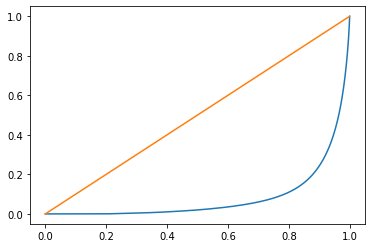

In [66]:
import matplotlib.pyplot as plt


tmp = N[:,1,:]
play = tmp.flatten()
s_c = sum(play)
plays2= play/s_c
plays2 = np.sort(plays2)
plays3 = np.cumsum(plays2)
x = np.linspace(0,1,num=len(plays2))
a = np.argmax(x-plays3)
scale = np.percentile(plays2[a:]*s_c,50)
((tmp * (tmp > scale)).sum(1)+1) / ((tmp > scale).sum(1)+1)

plt.plot(x, plays3)
plt.plot(x, x)
#plt.plot([0,1], [scale, scale])

In [71]:
scale = np.percentile(plays2[a:]*s_c,50)
scale

60.24888380979019

array([ 56.87925303, 252.44300489,  94.62819591, ...,   1.        ,
        72.09300348, 107.78048942])

In [85]:
(tmp > scale).sum(1)

array([ 5, 28, 19, ...,  0,  4,  5])

In [59]:
np.percentile(plays3[a:],50)

0.2820717665636271

In [58]:
np.argmax(x-plays3), len(plays3), len(plays3[a:])

(6502000, 7825300, 1323300)

In [54]:
np.percentile(plays3[a:])

TypeError: _percentile_dispatcher() missing 1 required positional argument: 'q'

In [55]:
plays3[a:]

array([0.1361176 , 0.13611773, 0.13611786, ..., 0.9999458 , 0.99997287,
       1.        ])

In [62]:



tmp > scale

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

0.6947771669766885

In [17]:
S = pickle.load(open("data/LR.p","rb"))
N = bgrun.runTMM(np.nan_to_num(S))

T = N.mean(2)
w = np.array(BED['End'] - BED['Start'])
t = T / w[:,None]
T = ((T / w[:,None]) / t.sum(0)) * 10**6
idx = T.std(1) != 0
F = T[idx,:]
#Z = ( F - F.mean(1)[:,None] ) / F.std(1)[:,None]

bed = BED.iloc[idx,:]
#N = np.nan_to_num(N).mean(2)

samples = list(meta.groupby('Name').groups.keys())
F = pd.DataFrame(F, columns=samples, index=bed['Name'])
F.to_csv('../data/TABLE/LR.RPKM.tsv', sep='\t')





(83272, 140)

In [19]:

path = '/groups/lackgrp/ll_members/berkay/1-notebook/col-matt-LNCaP/data/CHIPALTAS/BW_FINAL'
meta = pd.DataFrame({'Samples': \
    [f"{signal}_{h}_1" for signal in ["ATAC","H3K27ac", "H3K4me3", 'AR', 'FOXA1'] for h in ["VEH","TRE"]] + \
    ['_'.join(s.split('/')[-1].split('.')[0].split('_')[:3]) for s in  [f'{path}/{f}' for f in os.listdir(path) if f.find('.bw') != -1]] + \
    ['STARR_TRE_1','STARR_TRE_2','STARR_TRE_3', 'STARR_VEH_1','STARR_VEH_2','STARR_VEH_3']})


meta['Name'] = meta['Samples'].str.rsplit('_',1, expand=True)[0]


S = np.zeros((N.shape[0], meta['Name'].nunique()))
i = 0
for n, idx in meta.groupby('Name').groups.items():
    S[:,i] = N[:,idx].mean(1)
    i+=1



In [16]:
S

,ARID1A_TRE,ARID1A_VEH,AR_TRE,AR_VEH,ATAC_TRE,ATAC_VEH,BRD4_TRE,BRG1_TRE,BRG1_VEH,CHD1_TRE,...,TRIM24_TRE,TRIM24_VEH,TRIM28_TRE,TRIM28_VEH,WDHD1_TRE,WDHD1_VEH,WDR5_TRE,WDR5_VEH,XBP1s_TRE,XBP1s_VEH
Name,,,,,,,,,,,,,,,,,,,,,
chr1:751985-756985,-0.248107,-0.048826,-0.425956,1.369230,1.081740,-0.813536,1.503580,0.059472,0.127103,1.173083,...,0.355957,-2.523703,-0.492269,-0.156661,-0.488181,0.370871,-0.490864,-0.279201,0.617870,0.090242
chr1:760223-765223,-0.306613,-0.292840,-0.067147,-0.310947,1.120409,1.063142,0.302792,-0.276421,-0.261955,-0.147276,...,0.174482,0.612539,-0.265783,-0.245225,-0.231701,-0.208973,-0.026828,-0.137377,-0.165303,-0.162751
chr1:791444-796444,-0.102849,-0.194552,-0.712483,0.305925,1.114346,2.013233,1.636777,0.290780,-0.008171,0.221128,...,1.701915,1.509886,0.029611,0.762334,0.164770,0.106727,-0.131016,-0.191389,-0.239224,-0.017906
chr1:802847-807847,-0.261344,-0.089844,0.339564,0.150151,0.621576,2.090059,-0.347573,-0.107923,-0.115520,-0.350698,...,0.969333,0.955102,0.360914,0.318886,-0.185631,0.029516,-0.123710,0.527484,0.070156,-0.018281
chr1:863945-868945,-0.389440,-0.229691,0.263533,0.682197,4.632899,4.343140,1.125244,-0.257790,-0.172444,-0.226390,...,0.595748,0.622922,-0.280039,-0.144019,-0.361569,-0.164265,-0.055856,-0.239708,-0.334859,-0.410011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:28496921-28501921,-0.063607,0.518077,-1.962365,-1.311839,-1.151421,-0.826374,-0.514681,0.317080,0.194036,0.479142,...,1.439179,-2.390180,0.316800,0.901653,0.519706,0.127393,0.678388,1.220971,0.065434,0.251421
chrY:28508739-28513739,0.486958,0.600785,0.678677,-1.433068,0.402310,-1.653726,0.064804,0.534452,0.477519,-1.832060,...,-1.832060,-1.832060,0.318011,0.458146,0.490089,0.432880,0.590745,0.912196,0.258502,0.373716
chrY:28534627-28539627,0.151480,0.046823,-1.513382,-1.362316,-0.461868,-0.519569,-0.153958,0.506634,0.473749,2.052114,...,-1.897527,-1.897527,0.205796,0.129756,0.140872,0.230698,0.205102,-1.897527,0.208516,0.169644


In [10]:
meta.groupby('Name').groups.items()

dict_items([('ARID1A_TRE', Int64Index([92, 104], dtype='int64')), ('ARID1A_VEH', Int64Index([57, 111], dtype='int64')), ('AR_TRE', Int64Index([7], dtype='int64')), ('AR_VEH', Int64Index([6], dtype='int64')), ('ATAC_TRE', Int64Index([1], dtype='int64')), ('ATAC_VEH', Int64Index([0], dtype='int64')), ('BRD4_TRE', Int64Index([83], dtype='int64')), ('BRG1_TRE', Int64Index([41, 76], dtype='int64')), ('BRG1_VEH', Int64Index([24, 127], dtype='int64')), ('CHD1_TRE', Int64Index([73], dtype='int64')), ('CHD1_VEH', Int64Index([133], dtype='int64')), ('CHD4_CM', Int64Index([107], dtype='int64')), ('CK2A_TRE', Int64Index([82], dtype='int64')), ('CMYC_TRE', Int64Index([42, 55], dtype='int64')), ('CREB1_CM', Int64Index([52], dtype='int64')), ('CREB5_CM', Int64Index([12, 18, 28, 98], dtype='int64')), ('CTBP1_TRE', Int64Index([80], dtype='int64')), ('CTBP1_VEH', Int64Index([13], dtype='int64')), ('CTBP2_TRE', Int64Index([63], dtype='int64')), ('CTBP2_VEH', Int64Index([11], dtype='int64')), ('CTCF_TRE',

In [18]:
def scaling (array, factor):
	"""
	Here we perform background scaling
	"""
	mean = factor[0]
	array_2 = array+mean
	return array/array_2

def SES(array):
	"""
	SES normalization of the data.
	Returns the medium value for scaling and cutoff value
	"""
	values = np.zeros(4)
	play = array.flatten()
	s_c = sum(play)
	plays2 = play/s_c
	plays2 = np.sort(plays2)
	plays3 = np.cumsum(plays2)
	x = np.linspace(0,1,num=len(plays2))
	a = np.argmax(x-plays3)
	scale_min = plays2[a] * s_c
	mean = np.percentile(plays2[a:]*s_c,50)
	return mean, scale_min

def scaling3(array):
	"""
	Same as SES scaling, but only outputs the final scaled scores.
	"""
	values = np.zeros(4)
	play = array.flatten()
	s_c = sum(play)
	plays2= play/s_c
	plays2 = np.sort(plays2)
	plays3 = np.cumsum(plays2)
	x = np.linspace(0,1,num=len(plays2))
	a = np.argmax(x-plays3)
	scale_min = plays2[a]*s_c
	mean = np.percentile(plays2[a:]*s_c,50)
	values[0] = mean
	scale = np.percentile(plays2[a:]*s_c,95)
	print('Background Score',np.round(scale_min,2),'Max Score',np.round(scale,2),'Median Score',np.round(mean,2))
	array = scaling(array,[mean,mean-scale_min])
	return array


In [19]:
SS = np.zeros(S.shape[:2])

samples = list(meta.groupby('Name').groups.keys())
#SES_c = np.zeros((102,2))
for i in range(S.shape[1]):
	print(samples[i], end='::')
	SS[:, i] = scaling3(S[:,i,:]).mean(1)
	

ARID1A_TRE::Background Score 11.89 Max Score 58.44 Median Score 19.44
ARID1A_VEH::Background Score 9.19 Max Score 36.65 Median Score 18.24
AR_TRE::Background Score 8.57 Max Score 47.13 Median Score 17.14
AR_VEH::Background Score 9.47 Max Score 33.15 Median Score 18.94
ATAC_TRE::Background Score 19.07 Max Score 138.28 Median Score 40.79
ATAC_VEH::Background Score 19.09 Max Score 147.96 Median Score 42.44
BRD4_TRE::Background Score 10.76 Max Score 59.21 Median Score 21.53
BRG1_TRE::Background Score 8.35 Max Score 37.41 Median Score 16.65
BRG1_VEH::Background Score 8.95 Max Score 30.33 Median Score 16.41
CHD1_TRE::Background Score 0.0 Max Score 47.87 Median Score 15.96
CHD1_VEH::Background Score 10.3 Max Score 51.5 Median Score 20.6
CHD4_CM::Background Score 7.98 Max Score 23.94 Median Score 15.96
CK2A_TRE::Background Score 8.06 Max Score 72.54 Median Score 24.18
CMYC_TRE::Background Score 11.1 Max Score 77.49 Median Score 22.17
CREB1_CM::Background Score 12.2 Max Score 100.67 Median Scor

In [20]:
SS = pd.DataFrame(SS, columns=samples, index=BED['Name'])

SS.to_csv('../data/TABLE/LR.SES.tsv', sep='\t')

In [21]:
SS.columns[SS.columns.str.find('MYLB2') != -1]

Index([], dtype='object')

In [14]:
N.shape[1]

104

In [ ]:
S = pickle.load(open("data/LR.p","rb"))
N = bgrun.runTMM(S)[:,:,0]
N = pd.DataFrame(N, columns=[s.rsplit('_',3)[0] for s in samples], index=BED['Name'])
#N = pd.DataFrame(N, columns=samples, index=BED['Name'])
N.to_csv('../data/TABLE/LR.tmm.tsv', sep='\t')

In [ ]:
N.shape

In [ ]:
N == None

In [ ]:
sns.histplot(np.log2(((F+1) / (R+1))))

In [ ]:
R

In [ ]:
S